# Uber market demand prediction using seasonal ARIMA with grid search

Market demand plays a crucial part in the marketing strategy of any company. Forecasting such demand becomes crucial when the market is filled with competition, and a small mismatch in supply and demand can lead to a customer switching to another service provider.

In this notebook we look at a classical algorithm(ARIMA) which can be used to predict the demand for user trips in the upcoming week for a particular location. Particularly, we will be utilizing Uber's 2014 user trips data of New York city, to accomplish the same.

The dataset can be found on kaggle.com(https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city)

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

First we upload our data-set into a single data-frame:

In [3]:
#Preparing the uber 2014 main dataset
def prepare_2014_df():
    
    #Loading datasets
    uber_2014_apr=pd.read_csv('uber-raw-data-apr14.csv',header=0)
    uber_2014_may=pd.read_csv('uber-raw-data-may14.csv',header=0)
    uber_2014_jun=pd.read_csv('uber-raw-data-jun14.csv',header=0)
    uber_2014_jul=pd.read_csv('uber-raw-data-jul14.csv',header=0)
    uber_2014_aug=pd.read_csv('uber-raw-data-aug14.csv',header=0)
    uber_2014_sep=pd.read_csv('uber-raw-data-sep14.csv',header=0)
    
    #Merging
    df = uber_2014_apr.append([uber_2014_may,uber_2014_jun,uber_2014_jul,uber_2014_aug,uber_2014_sep], ignore_index=True)
    
    #returning merged dataframe
    return df

#Uber 2014 dataset
uber_2014_master = prepare_2014_df()
uber_2014_master.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


## Feature Engineering

Next, we prepare the data-frame so that it is in a time-series format, which can then be utilized for modelling.
Since we are only looking at a basic time-series forecast model, we will only be utilizing the Date/Time column for now.

I plan to predict the demand at a day level and hence we will be resampling the data at a day level. However deping on the need, we can sample the data at different levels(Hour,Month,Year etc.)

In [4]:
# Feature Engineering
def create_day_series(df):
    
    # Grouping by Date/Time to calculate number of trips
    day_df = pd.Series(df.groupby(['Date/Time']).size())
    # setting Date/Time as index
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling to daily trips
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

day_df_2014 = create_day_series(uber_2014_master)
day_df_2014.head()

Date/Time
2014-04-01    14546
2014-04-02    17474
2014-04-03    20701
2014-04-04    26714
2014-04-05    19521
Freq: D, dtype: int64

Now that we have the time-series data-frame ready, we can look into some initial visualizations of the data to decide our parameters for the ARIMA model

p-value: 0.84589808249


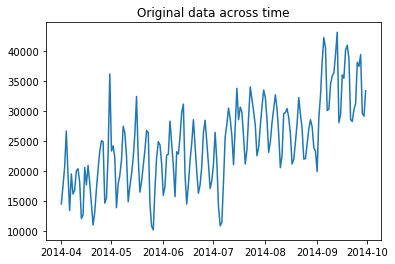

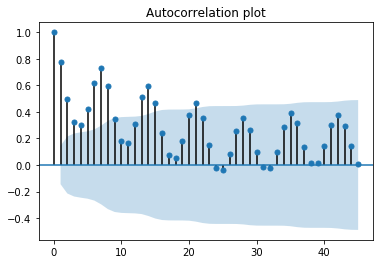

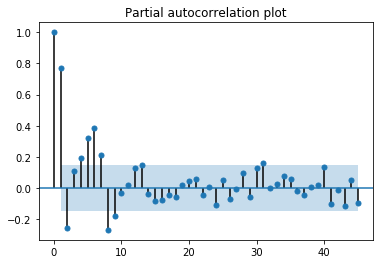

In [5]:
#Checking trend and autocorrelation
def initial_plots(time_series, num_lag):

    #Original timeseries plot
    plt.figure(1)
    plt.plot(time_series)
    plt.title('Original data across time')
    plt.figure(2)
    plot_acf(time_series, lags = num_lag)
    plt.title('Autocorrelation plot')
    plot_pacf(time_series, lags = num_lag)
    plt.title('Partial autocorrelation plot')
    
    plt.show()

    
#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(day_df_2014)[1]))

#plotting
initial_plots(day_df_2014, 45)

Looking at the ADF test we see that clearly the time-series is not stationary(p-value>0.05 i.e for a confidence level of 95%), hence differencing is required.

Before we even analyse the ACF and PACF plots we need to difference and test for stationarity

In [6]:
#storing differenced series
diff_series = day_df_2014.diff(periods=1)

#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(diff_series.dropna())[1]))

p-value: 1.51636411774e-08


Looks like the series is stationary now (as p-value < 0.05, we can assume stationarity with a confidence level of 95%, even higher actually). So a differencing of 1 should be perfect!

Now lets look at the ACF and PACF plots:

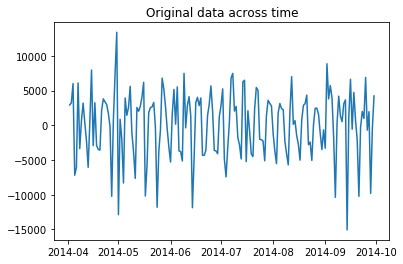

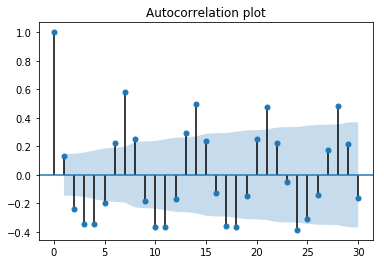

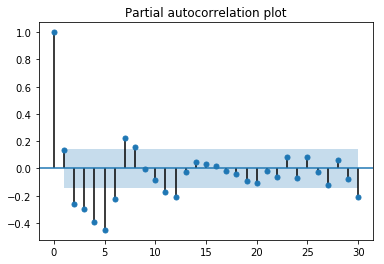

In [7]:
initial_plots(diff_series.dropna(), 30)

From the ACF and PACF plots we can see a clear spike at every 7 day interval. And since this appears clearly in the ACF plot this whows a seasonal MA component of 1.

## Fitting SARIMAX models

Although at this point the components can be guessed at ARIMA(0,1,0)(0,0,1)[7], we will implement a grid search to find the best fitting values, using RMSE as the deciding factor:

In [8]:
#Defining RMSE
def rmse(x,y):
    return sqrt(mean_squared_error(x,y))

#fitting ARIMA model on dataset
def SARIMAX_call(time_series,p_list,d_list,q_list,P_list,D_list,Q_list,s_list,test_period):    
    
    #Splitting into training and testing
    training_ts = time_series[:-test_period]
    
    testing_ts = time_series[len(time_series)-test_period:]
    
    error_table = pd.DataFrame(columns = ['p','d','q','P','D','Q','s','AIC','BIC','RMSE'],\
                                                           index = range(len(ns_ar)*len(ns_diff)*len(ns_ma)*len(s_ar)\
                                                                         *len(s_diff)*len(s_ma)*len(s_list)))
    count = 0
    
    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            for s in s_list:
                                #fitting the model
                                SARIMAX_model = SARIMAX(training_ts.astype(float),\
                                                        order=(p,d,q),\
                                                        seasonal_order=(P,D,Q,s),\
                                                        enforce_invertibility=False)
                                SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
                                AIC = np.round(SARIMAX_model_fit.aic,2)
                                BIC = np.round(SARIMAX_model_fit.bic,2)
                                predictions = SARIMAX_model_fit.forecast(steps=test_period,typ='levels')
                                RMSE = rmse(testing_ts.values,predictions.values)                                

                                #populating error table
                                error_table['p'][count] = p
                                error_table['d'][count] = d
                                error_table['q'][count] = q
                                error_table['P'][count] = P
                                error_table['D'][count] = D
                                error_table['Q'][count] = Q
                                error_table['s'][count] = s
                                error_table['AIC'][count] = AIC
                                error_table['BIC'][count] = BIC
                                error_table['RMSE'][count] = RMSE
                                
                                count+=1 #incrementing count        
    
    #returning the fitted model and values
    return error_table

ns_ar = [0,1,2]
ns_diff = [1]
ns_ma = [0,1,2]
s_ar = [0,1]
s_diff = [0,1] 
s_ma = [1,2]
s_list = [7]

error_table = SARIMAX_call(day_df_2014,ns_ar,ns_diff,ns_ma,s_ar,s_diff,s_ma,s_list,30)

C:\Users\Kruthik Heggade\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Kruthik Heggade\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Kruthik Heggade\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Kruthik Heggade\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceW

Now that we have obtained the RMSE values for different combinations, we can take a look at the lowest 5 RMSE values:

In [9]:
# printing top 5 lowest RMSE from error table
error_table.sort_values(by='RMSE').head(5)

,p,d,q,P,D,Q,s,AIC,BIC,RMSE
5,0,1,0,1,0,2,7,2903.28,2915.4,5057.25
3,0,1,0,0,1,2,7,2752.78,2761.87,5105.3
7,0,1,0,1,1,2,7,2754.8,2766.92,5136.57
6,0,1,0,1,1,1,7,2754.5,2763.6,5278.11
2,0,1,0,0,1,1,7,2752.71,2758.77,5336.34


We see that ARIMA(0,1,0)(1,0,2)[7] gives the lowest RMSE. However, next best RMSE is of ARIMA(0,1,0)(0,1,2)[7] has lower AIC and BIC scores, which tells us that it fits the data much better than the lowest RMSE ARIMA fit.

Here we can chose the second ARIMA if we want a more robust solution, which can generalize well to other situations as well, however this ensures that we do not get the best RMSE for this testing data.

## Forecasting

I will forecast using ARIMA(0,1,0)(0,1,2)[7] as I want the model to fit the data better along with giving me a lower RMSE:

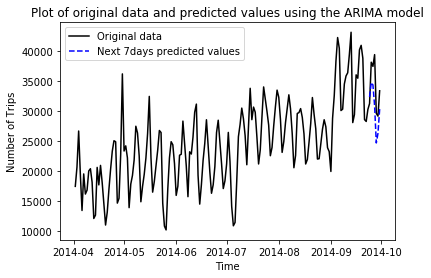

In [10]:
#Predicting values using the fitted model
def predict(time_series,p,d,q,P,D,Q,s,n_days,conf):
    
    #Splitting into training and testing
    training_ts = time_series[:-n_days]
    
    testing_ts = time_series[len(time_series)-n_days:]
    
    #fitting the model
    SARIMAX_model = SARIMAX(training_ts.astype(float),\
                            order=(p,d,q),\
                            seasonal_order=(P,D,Q,s),\
                            enforce_invertibility=False)
    SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
    
    #Predicting
    SARIMAX_prediction = pd.DataFrame(SARIMAX_model_fit.forecast(steps=n_days,alpha=(1-conf)).values,\
                          columns=['Prediction'])
    SARIMAX_prediction.index = pd.date_range(training_ts.index.max()+1,periods=n_days)
    
    #Plotting
    plt.figure(4)
    plt.title('Plot of original data and predicted values using the ARIMA model')
    plt.xlabel('Time')
    plt.ylabel('Number of Trips')
    plt.plot(time_series[1:],'k-', label='Original data')
    plt.plot(SARIMAX_prediction,'b--', label='Next {}days predicted values'.format(n_days))
    plt.legend()
    plt.show()
    
    #Returning predicitons
    return SARIMAX_prediction

#Predicting the values and builing an 80% confidence interval
prediction = predict(day_df_2014,0,1,0,0,1,2,7,7,0.80)

Thus using this simple classical Seasonal ARIMA model we can utilize the forecasted data to plan and alter our marketing strategy for the upcoming week(or any timeframe upon which predictions are to be made) in any location.

In this example, I have just used the complete dataset to forecast the demand, however we need not restrict ourselves to this level. We can split the data-set based on location and obtain forecasts for different pick-up zones in NYC(which would add even more value towards our predictions).